In [1]:
from sklearn import linear_model, model_selection, metrics, pipeline, preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import joblib

In [2]:
# for random state
RSEED = 50

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
df = pd.read_csv("bike_sharing_demand.csv")
#df.head()

In [5]:
#print(df.shape)

In [6]:
#df.info()

In [7]:
#df.describe()

In [8]:
df.datetime = pd.to_datetime(df.datetime)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [10]:
df['month'] = df.datetime.apply(lambda x : x.month)
df['hour'] = df.datetime.apply(lambda x : x.hour)

In [11]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


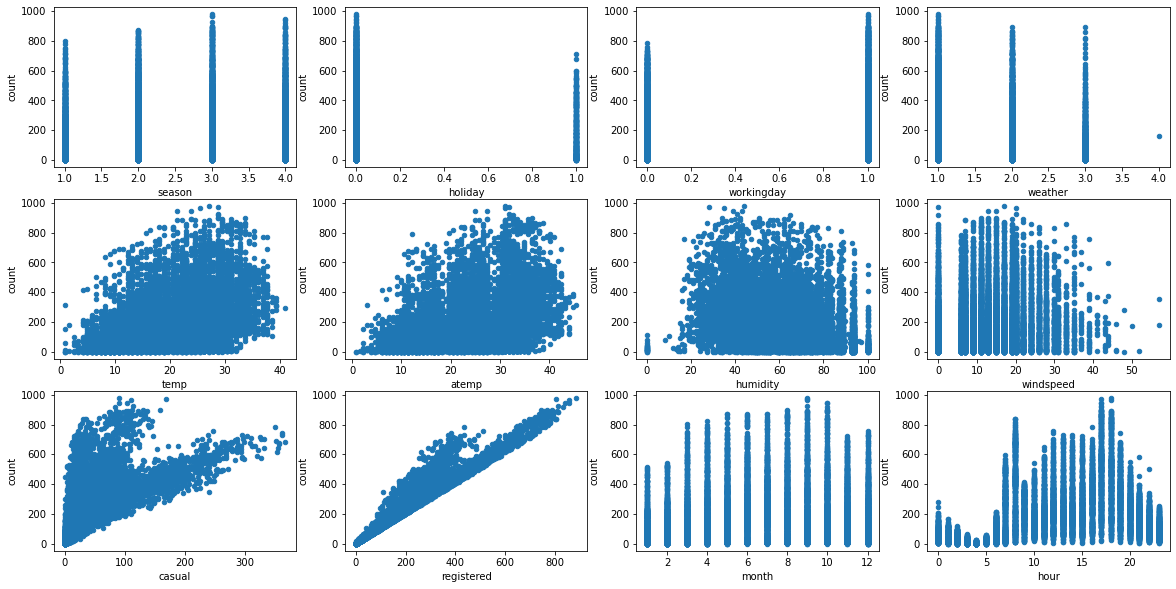

In [12]:
# Dependence of count on features
graph_df = df.drop('datetime', axis = 1)
fig, axes = pylab.subplots(3, 4, figsize = (20, 10))
for idx, feature in enumerate(graph_df.loc[:, graph_df.columns != 'count'].columns):
    graph_df.plot(feature, 'count', subplots = True, kind = 'scatter', ax = axes[idx//4, idx%4])

### Casual and Registered are almost linearly dependent on the count
### Let's see the heat map

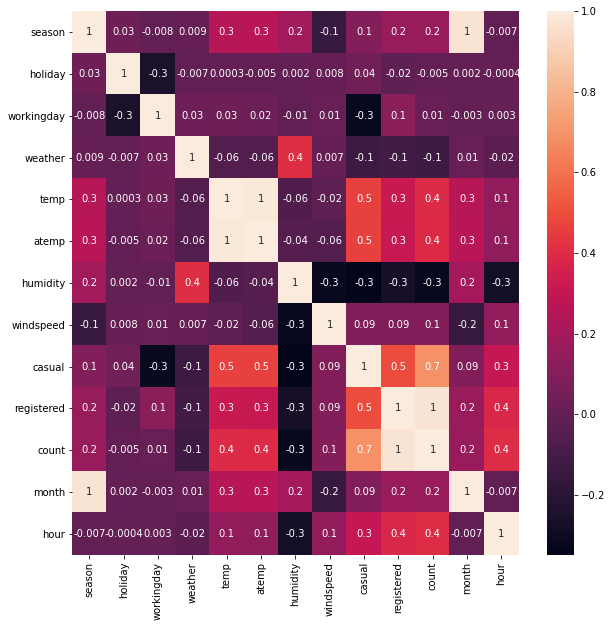

In [13]:
pylab.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot = True, fmt = '.1g')


<h3>Registered and Casual are completely correlated with count. These features should be removed before training the model</h3>

### Split data into training and test

In [14]:
train_data = df.iloc[:-1000]
holdout_test_data = df.iloc[-1000:]

In [15]:
print(df.shape, train_data.shape, holdout_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [16]:
print("train period from {} to {}".format(train_data.datetime.min(), train_data.datetime.max()))
print("evaluation period from {} to {}".format(holdout_test_data.datetime.min(), holdout_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


### Split data into features and labels

In [17]:
# training
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [18]:
# test
test_labels = holdout_test_data['count']
test_data = holdout_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

### "Count" distribution on training set and test set

Text(0.5, 1.0, 'test data')

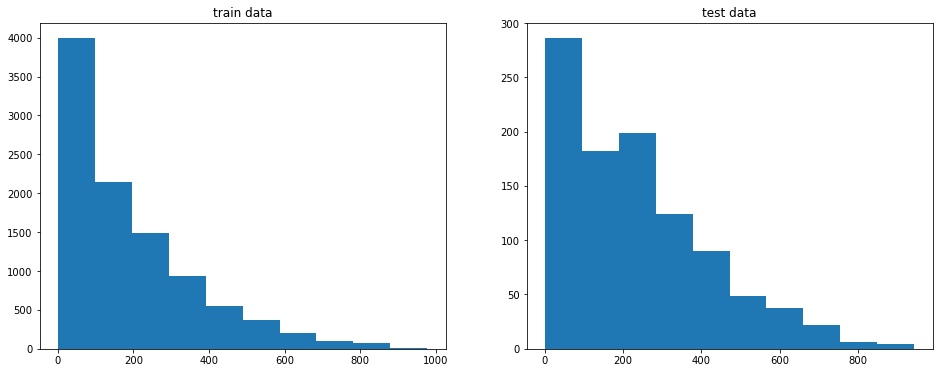

In [19]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

<h3>Next, I will split the features into 3 categories:</h3>
<ol>
<li>Numeric</li>
<li>Binary</li>
<li>Categorical</li>
</ol>

#### Numeric features

In [20]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed','hour']
numeric_data_indiciens = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)
print(numeric_data_columns)
print(numeric_data_indiciens)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


<h4>Binary features</h4>

In [21]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indiciens = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)
print(binary_data_columns)
print(binary_data_indiciens)

['holiday', 'workingday']
[False  True  True False False False False False False False]


<h4>Categorical features</h4>

In [22]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indiciens = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)
print(categorical_data_columns)
print(categorical_data_indiciens)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


<h3>Random forest, pipeline, scaling</h3>

In [23]:
from sklearn.ensemble import RandomForestRegressor


In [24]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 20, min_samples_leaf = 2, random_state = RSEED, n_jobs = -1)

In [25]:
estimator = pipeline.Pipeline(steps = [
    ('feature_preprocessing', pipeline.FeatureUnion(transformer_list = [
        #binary
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[binary_data_columns])),
        
        #numeric
        ('numeric_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[numeric_data_columns])),
            ('scaling', preprocessing.StandardScaler(with_mean = 0, with_std = 1))
        ])),
        
        #categorical
        ('categorical_variables_processing', pipeline.Pipeline(steps = [
            ('selecting', preprocessing.FunctionTransformer(lambda data: data[categorical_data_columns])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))
        ])),
        

    ])),
    
    ('model_fitting', model)
    
])

In [26]:
%%time
estimator.fit(train_data, train_labels)

Wall time: 2.85 s


Pipeline(steps=[('feature_preprocessing',
                 FeatureUnion(transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(func=<function <lambda> at 0x000002067CFCBF70>)),
                                                ('numeric_variables_processing',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x000002067CFDE040>)),
                                                                 ('scaling',
                                                                  StandardScaler(with_mean=0,
                                                                                 with_std=1))])),
                                                ('categorical_variables_processing',
                                                 Pipeline(steps=[('selecting',
                              

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [28]:
print('Train Mean squared log error = ', mean_squared_log_error(train_labels, estimator.predict(train_data)))

Train Mean squared log error =  0.05963334865254185


In [29]:
print('Test Mean squared log error = ', mean_squared_log_error(test_labels, estimator.predict(test_data)))

Test Mean squared log error =  0.23442318079924668


In [35]:
test_labels[:10].values

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [31]:
estimator.predict(test_data)[:10]

array([357.5732619 , 536.18662698, 271.65340476, 156.30857305,
       211.21407937, 245.67590454, 235.38701787, 311.39326794,
       294.92260108, 408.91639286])

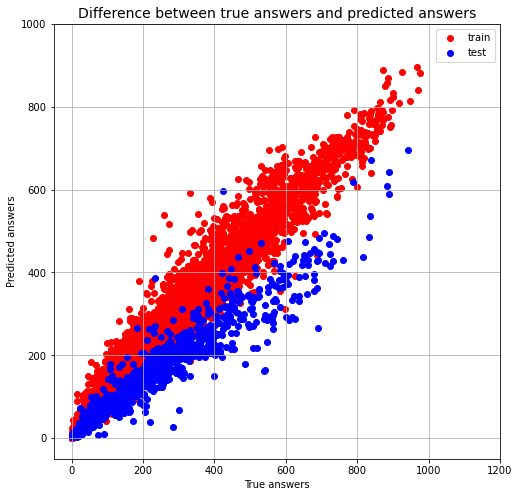

In [34]:
plt.figure(figsize=(8,8))
plt.title('Difference between true answers and predicted answers', fontsize = 14)
plt.xlabel('True answers')
plt.ylabel('Predicted answers')
plt.grid(True)
plt.xlim(-50, 1200)
plt.ylim(-50, 1000)
plt.scatter(train_labels, estimator.predict(train_data), color = 'red', label = 'train')
plt.scatter(test_labels, estimator.predict(test_data), color = 'blue', label = 'test')
plt.legend(loc = 'best')


<h4>Algorithm : RandomForest</h4>
<h4>Mean squared log error on the test: 0.23</h4>